In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import libraries

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC, SVR
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [3]:
from utils.ml_regression import train_and_evaluate_rf, train_and_evaluate_svr, train_and_evaluate_xgb, svr_grid_search

In [4]:
from utils.ml_regression import tune_xgb_hyperparameters_random as tune_xgb

# Load dataset

In [5]:
def calculate_cdf(series, num_points=1024):
    sorted_series = np.sort(series)
    cdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    sampled_points = np.linspace(np.min(sorted_series), np.max(sorted_series), num_points)
    sampled_cdf = np.interp(sampled_points, sorted_series, cdf)
    return sampled_cdf

In [6]:
def load_dataset(files):
    data_arr = []
    for file_path in files:
        data_raw = pd.read_csv(file_path).values.astype(np.float32)
        if len(data_raw[:, 1]) == 0:
            print(f"Warning: No data in {file_path}")
            continue


        # data = np.expand_dims(data_raw[:, 1], axis=1)
        min_length = min(min_length, len(data_raw[:, 1]))
        cdf_features = calculate_cdf(data_raw[:, 1])        
        data_arr.append(cdf_features)
    
    return np.array(data_arr)

In [7]:
def load_files(files, max_len=None):
    data_arr = []
    
    for filepath in files:
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        cdf = calculate_cdf(x)

        data_arr.append(cdf)
    
    return np.array(data_arr)

In [11]:
data_storage = {
    'Join': {
        'dirs': [
            '../nexmark_dataset/q3_join/actual_data',
            '../nexmark_dataset/q4_join_auction_bid/actual_data',
        ],
        'label': 2,
        'substring': 'process_time',
        'end_char': '.'
    },
    'Max_GroupBy': {
        'dirs': [
            '../nexmark_dataset/q6_max',
            '../nexmark_dataset/q4_max',
        ],
        'label': 3,
        'substring': 'tail_0',
        'end_char': '.'
    },
    'Avg_Sliding': {
        'dirs': [
            '../nexmark_dataset/q4_avg',
        ],
        'label': 4,
        'substring': 'tail_0',
        'end_char': '.'
    },
    'Avg_Partition': {
        'dirs': [
            '../nexmark_dataset/avg_partition',
        ],
        'label': 5,
        'substring': 'tail_0',
        'end_char': '_'
    },
    'Count_By_Auction': {
        'dirs': [
            '../nexmark_dataset/q5_count_by_auction',
        ],
        'label': 6,
        'substring': 'tail_0',
        'end_char': '.'
    },
}

In [12]:
class_names = [
    'Join', 
    'Max_GroupBy', 
    'Avg_Sliding', 
    'Avg_Partition',
    'Count_By_Auction',
]

In [13]:
data_files = {}
for operator in data_storage:
    data_files[operator] = {
        'files': [],
        'label': data_storage[operator]['label'],
    }

    for dir in data_storage[operator]['dirs']:
        files = [f for f in os.listdir(dir) if f.endswith('.csv')]
        data_files[operator]['files'].extend([os.path.join(dir, file) for file in files])

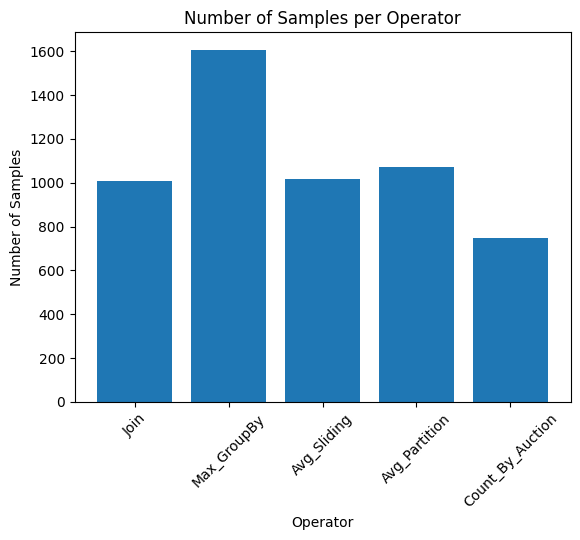

In [14]:
# Count the number of samples per operator
operator_counts = {operator: len(data_files[operator]['files']) for operator in data_files}

# Plot the data
plt.bar(operator_counts.keys(), operator_counts.values())
plt.xlabel('Operator')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Operator')
plt.xticks(rotation=45)
plt.show()

In [15]:
for operator in data_files:
    if operator == 'Join':
        data_files[operator]['train'] = data_files[operator]['files'][:504]
        data_files[operator]['test'] = data_files[operator]['files'][504:]
    elif operator == 'Map':
        data_files[operator]['train'] = data_files[operator]['files'][:494]
        data_files[operator]['test'] = data_files[operator]['files'][494:]
    elif operator == 'Filter':
        data_files[operator]['train'] = data_files[operator]['files'][:676]
        data_files[operator]['test'] = data_files[operator]['files'][676:]
    elif operator == 'Max_GroupBy':
        data_files[operator]['train'] = data_files[operator]['files'][:574]
        data_files[operator]['test'] = data_files[operator]['files'][1094:]
    else:
        train, test = train_test_split(data_files[operator]['files'], train_size=0.5, shuffle=True, random_state=42)
        data_files[operator]['train'] = train
        data_files[operator]['test'] = test
    # train, test = train_test_split(data_files[operator]['files'], train_size=0.5, shuffle=True, random_state=42)
    # data_files[operator]['train'] = train
    # data_files[operator]['test'] = test

    data_files[operator]['train_data'] = load_files(data_files[operator]['train'])
    data_files[operator]['test_data'] = load_files(data_files[operator]['test'])

    data_files[operator]['train_window_time'] = []
    data_files[operator]['train_sliding_step'] = []
    substring = data_storage[operator]['substring']
    end_char = data_storage[operator]['end_char']

    for file in data_files[operator]['train']:
        window_start_index = file.index(substring) + len(substring) + 1
        window_time = file[window_start_index:file.index('_', window_start_index)]
        data_files[operator]['train_window_time'].append(int(window_time))
        sliding_step = file[file.index('_', window_start_index) + 1:file.rindex(end_char, window_start_index)]
        data_files[operator]['train_sliding_step'].append(int(sliding_step))



    data_files[operator]['test_window_time'] = []
    data_files[operator]['test_sliding_step'] = []
    for file in data_files[operator]['test']:
        window_start_index = file.index(substring) + len(substring) + 1
        window_time = file[window_start_index:file.index('_', window_start_index)]
        data_files[operator]['test_window_time'].append(int(window_time))
        sliding_step = file[file.index('_', window_start_index) + 1:file.rindex(end_char, window_start_index)]
        data_files[operator]['test_sliding_step'].append(int(sliding_step))



In [17]:
def train_and_evaluate_ml_model(operator, variable_name, func, params):

    x_train = data_files[operator]['train_data']
    y_train = data_files[operator][f'train_{variable_name}']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator][f'test_{variable_name}']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    return func(x_train, y_train, x_test, y_test, **params)

# Random Forest

Training Random Forest for Join...
Mean Squared Error (MSE): 944.2624
R² Score: 0.9547


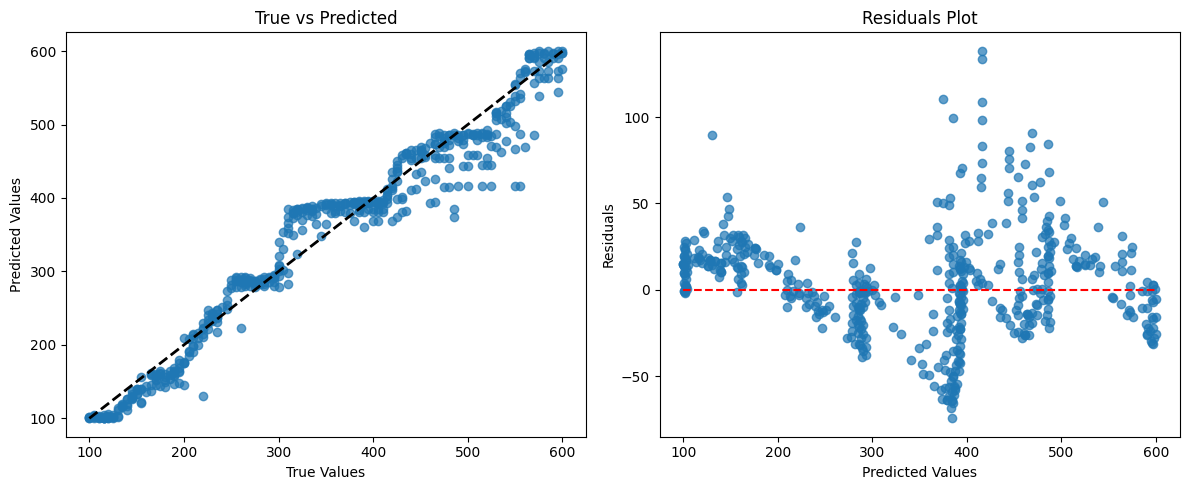

Training Random Forest for Max_GroupBy...
Mean Squared Error (MSE): 7487935.8999
R² Score: -2.6485


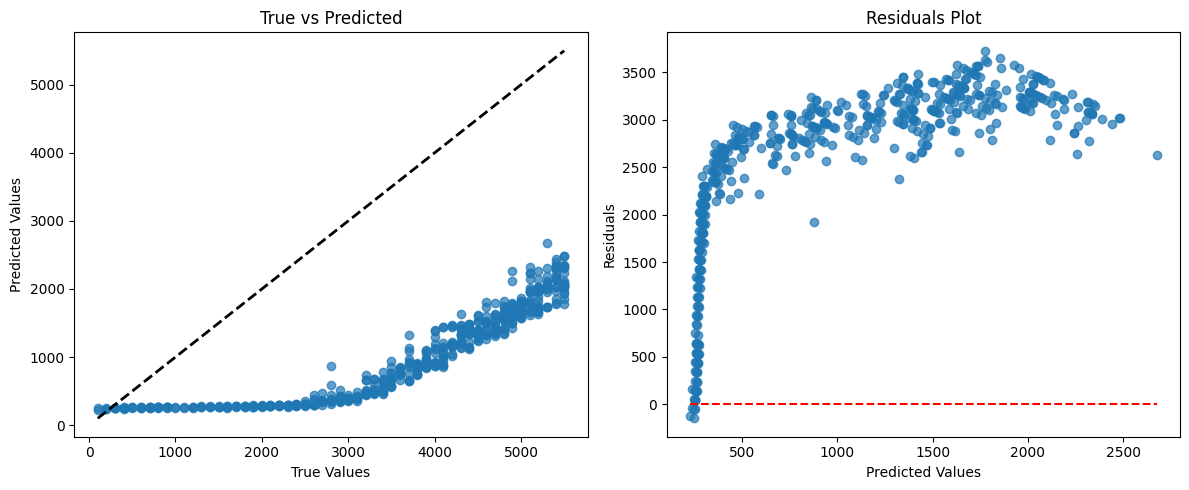

Training Random Forest for Avg_Sliding...
Mean Squared Error (MSE): 100066.6739
R² Score: 0.9729


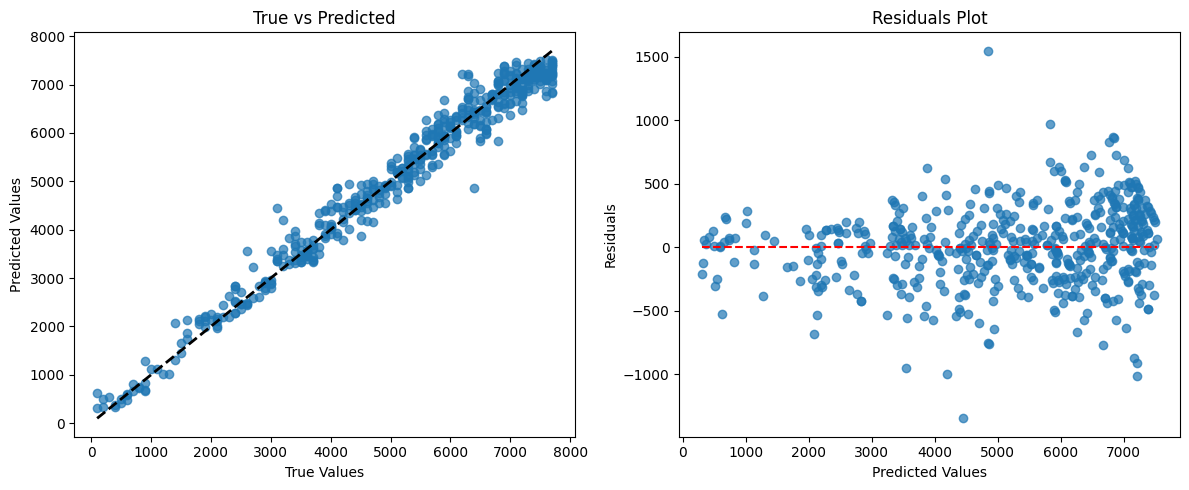

Training Random Forest for Avg_Partition...
Mean Squared Error (MSE): 110959.3819
R² Score: 0.8341


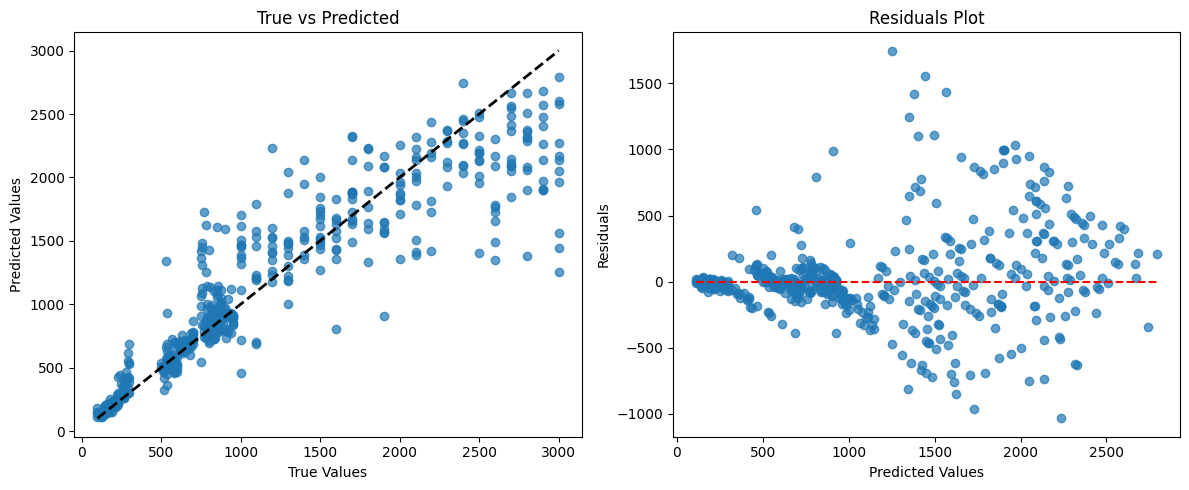

Training Random Forest for Count_By_Auction...
Mean Squared Error (MSE): 44.7476
R² Score: 0.9760


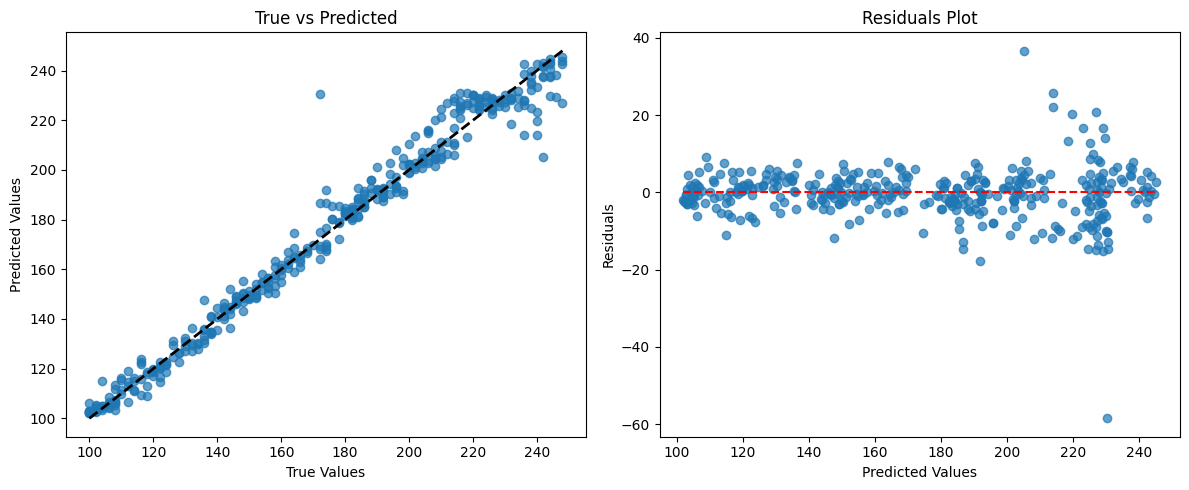

In [18]:
rf_window_models = {}

for operator in data_files:
    print(f"Training Random Forest for {operator}...")
    rf_window_models[operator] = train_and_evaluate_ml_model(operator, 'window_time', train_and_evaluate_rf, {
        'n_estimators': 200,
        'max_depth': None,
        'random_state': 42
    })

Training Random Forest for Join...
Mean Squared Error (MSE): 227.8183
R² Score: 0.7242


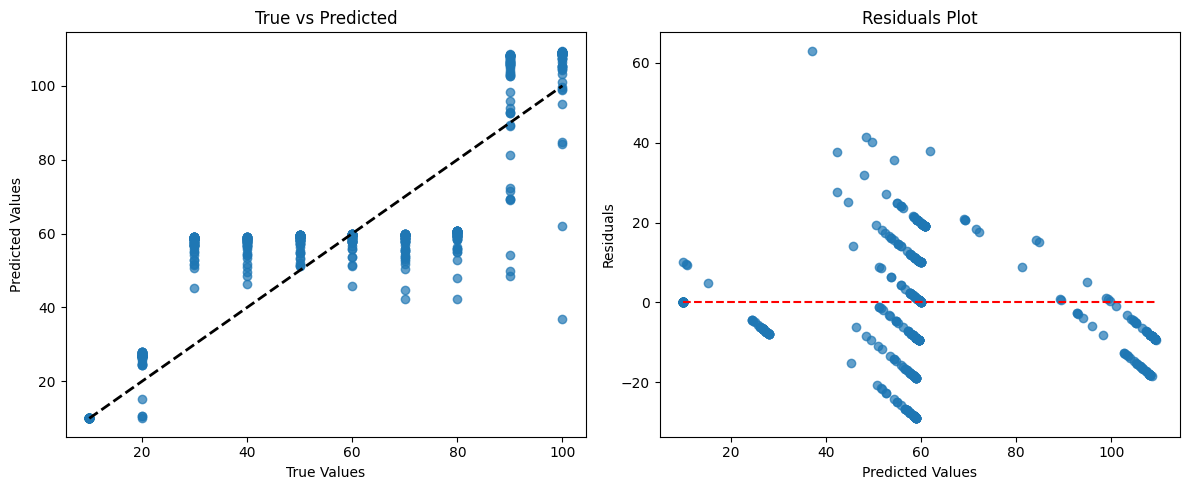

Training Random Forest for Max_GroupBy...
Mean Squared Error (MSE): 3135.2716
R² Score: 0.9964


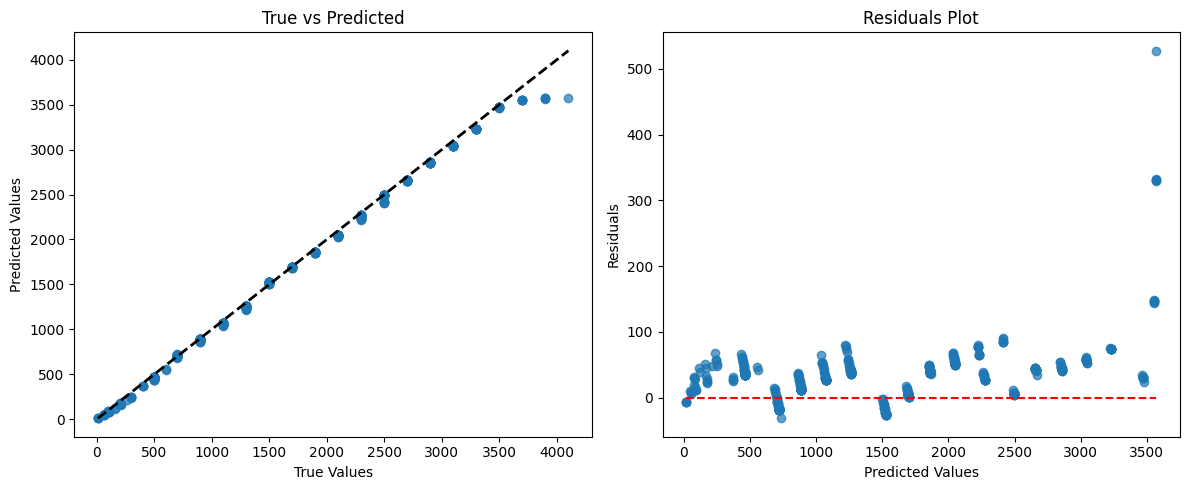

Training Random Forest for Avg_Sliding...
Mean Squared Error (MSE): 4610.8440
R² Score: 0.9972


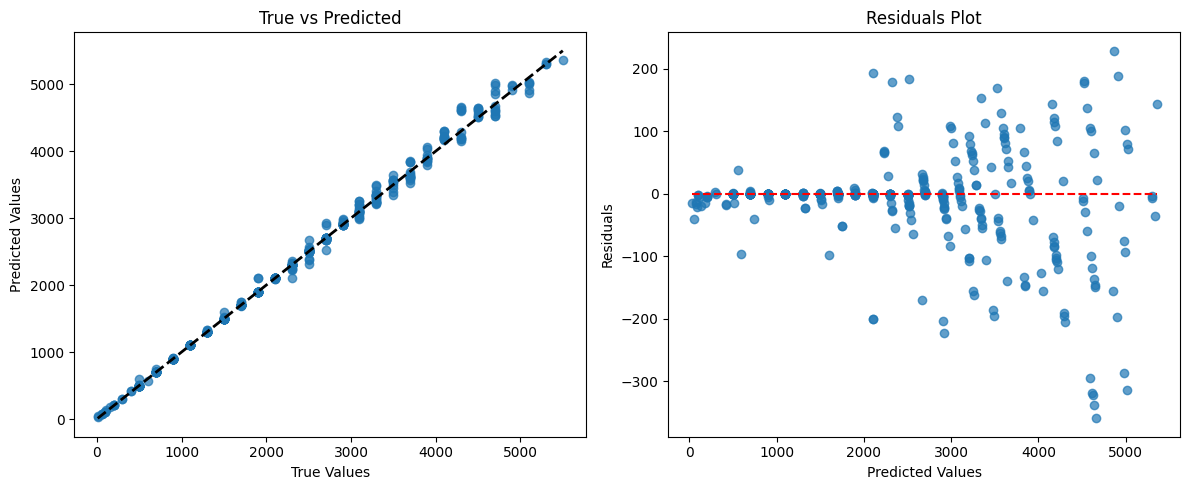

Training Random Forest for Avg_Partition...
Mean Squared Error (MSE): 3856.7395
R² Score: 0.8337


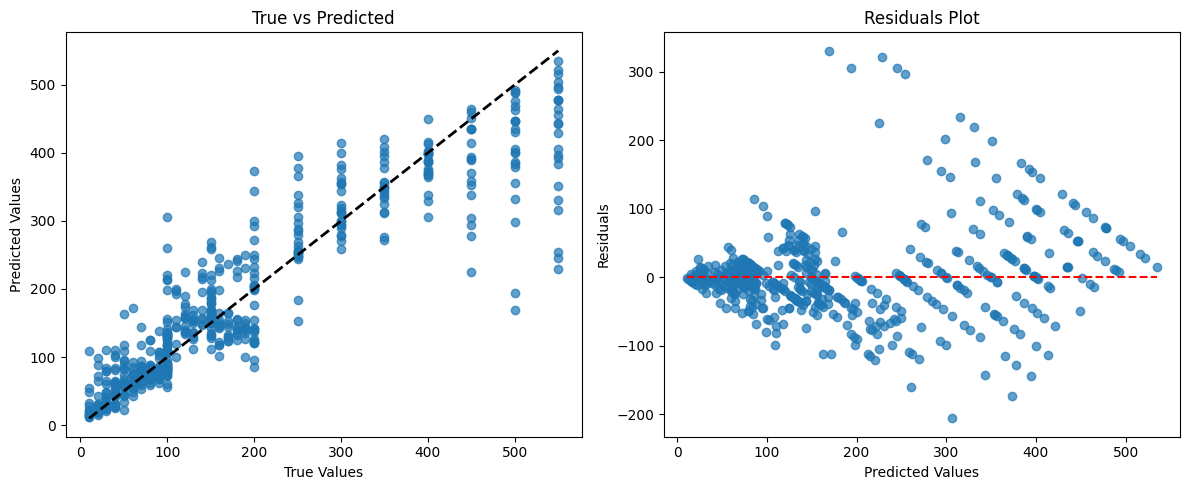

Training Random Forest for Count_By_Auction...
Mean Squared Error (MSE): 1.8093
R² Score: 0.9978


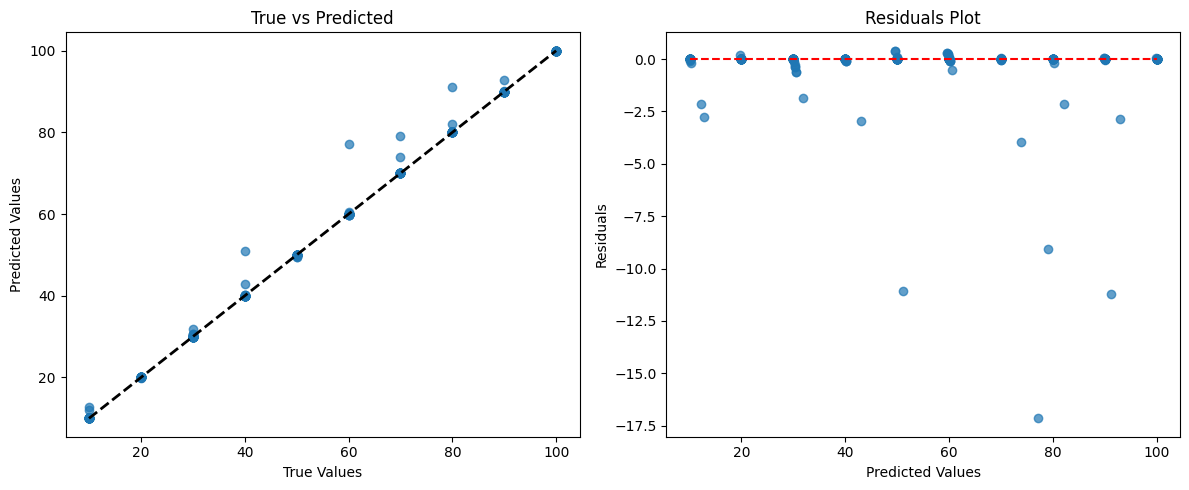

In [19]:
rf_sliding_step_models = {}

for operator in data_files:
    print(f"Training Random Forest for {operator}...")
    rf_sliding_step_models[operator] = train_and_evaluate_ml_model(operator, 'sliding_step', train_and_evaluate_rf, {
        'n_estimators': 200,
        'max_depth': None,
        'random_state': 42
    })

# SVM

Training SVR for Join...
Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}
Best cross-validation score: 0.8665365989605973
Mean Squared Error (MSE): 1570260.0502
R² Score: -74.3533


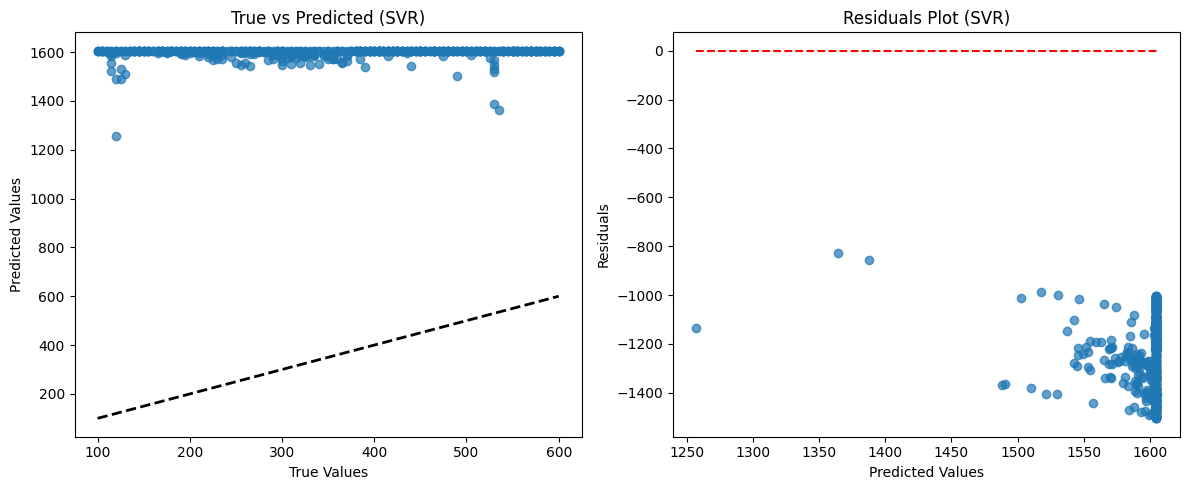

Training SVR for Max_GroupBy...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.9507812950357328
Mean Squared Error (MSE): 6198968.3407
R² Score: -2.0204


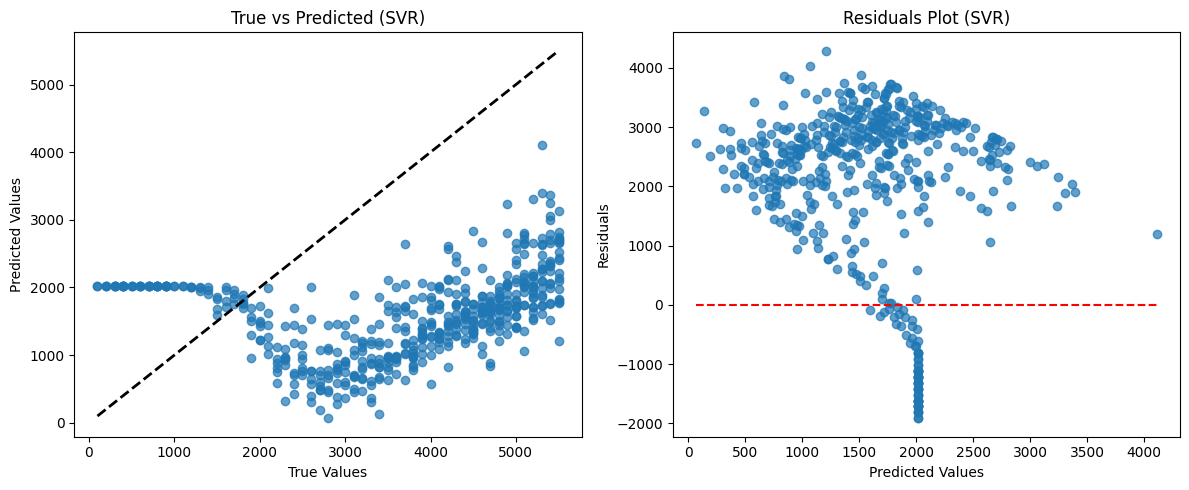

Training SVR for Avg_Sliding...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.01}
Best cross-validation score: 0.9105753105058121
Mean Squared Error (MSE): 289826.9969
R² Score: 0.9215


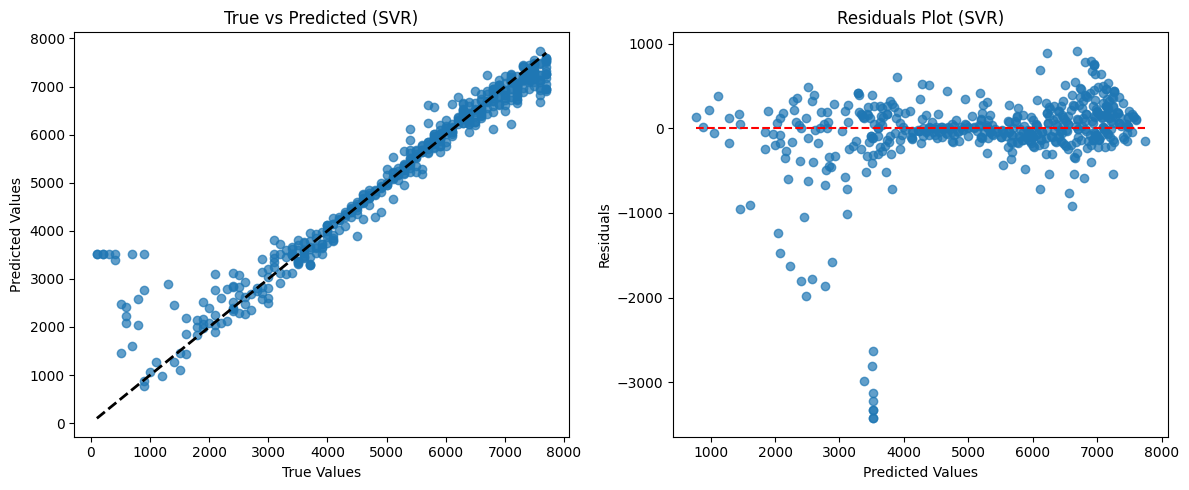

Training SVR for Avg_Partition...
Best parameters: {'C': 10, 'epsilon': 0.2, 'gamma': 'auto'}
Best cross-validation score: 0.6742394853658423
Mean Squared Error (MSE): 249924.6876
R² Score: 0.6263


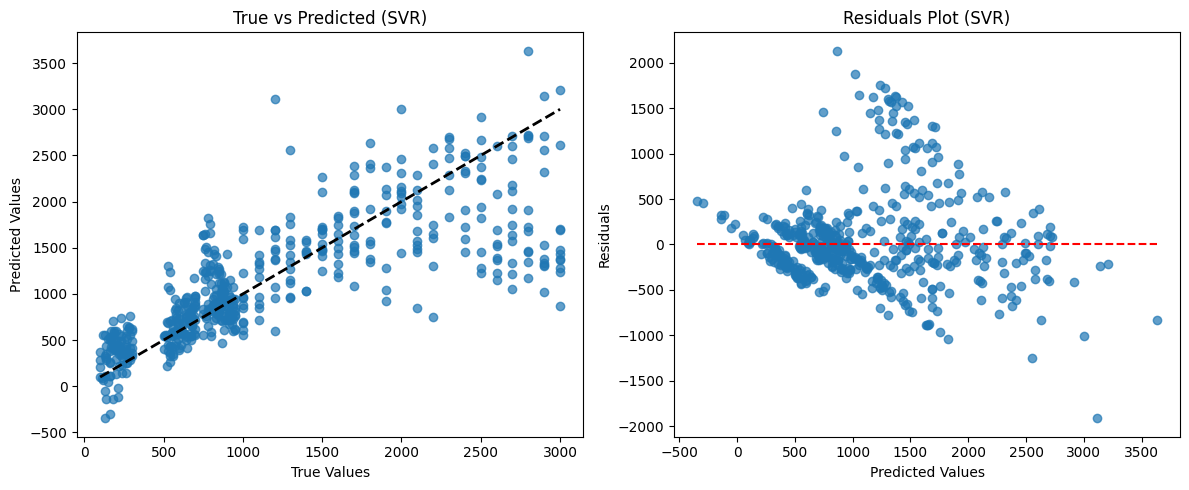

Training SVR for Count_By_Auction...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.9705324535424065
Mean Squared Error (MSE): 59.5204
R² Score: 0.9680


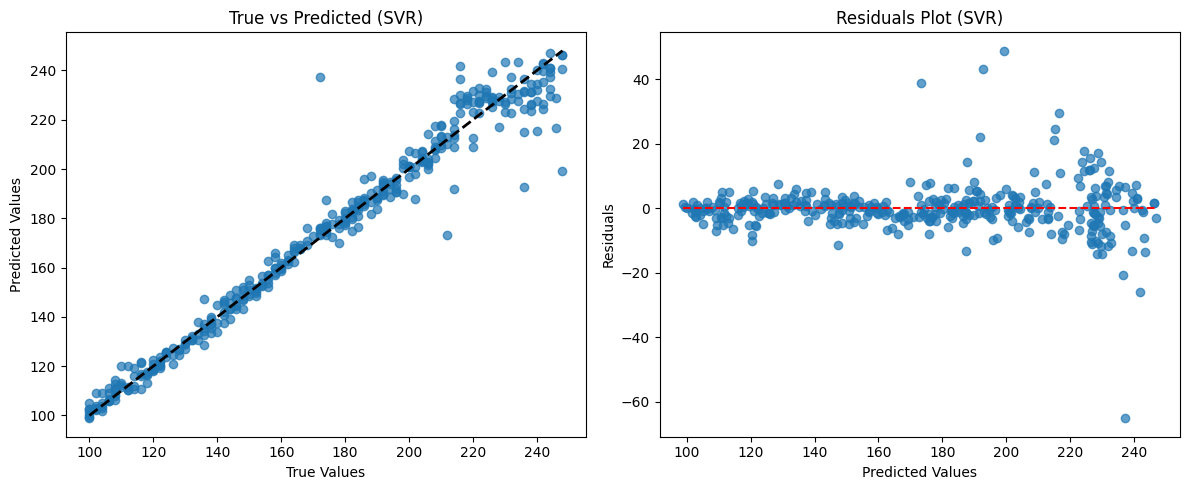

In [20]:
svr_window_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_window_time']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_window_time']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    svr_window_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    svr_window_models[operator]['model'], 
    svr_window_models[operator]['params'], 
    svr_window_models[operator]['scaler_x'], 
    svr_window_models[operator]['scaler_y'] = svr_grid_search(x_train, y_train, x_test, y_test)

Training SVR for Join...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.01}
Best cross-validation score: 0.875629716298475
Mean Squared Error (MSE): 38513.0943
R² Score: -45.6174


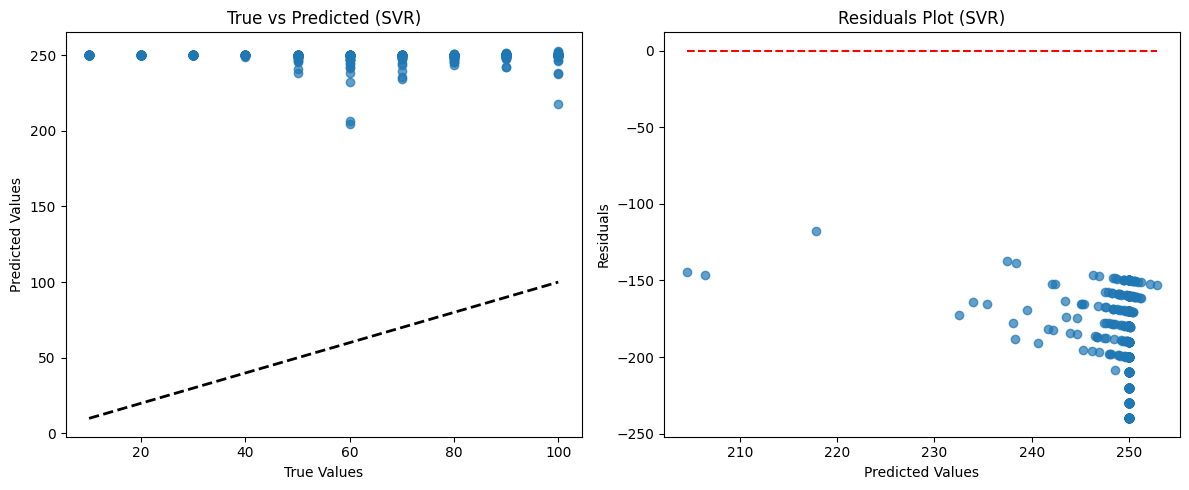

Training SVR for Max_GroupBy...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.01}
Best cross-validation score: 0.9673242117139338
Mean Squared Error (MSE): 784904.2239
R² Score: 0.1070


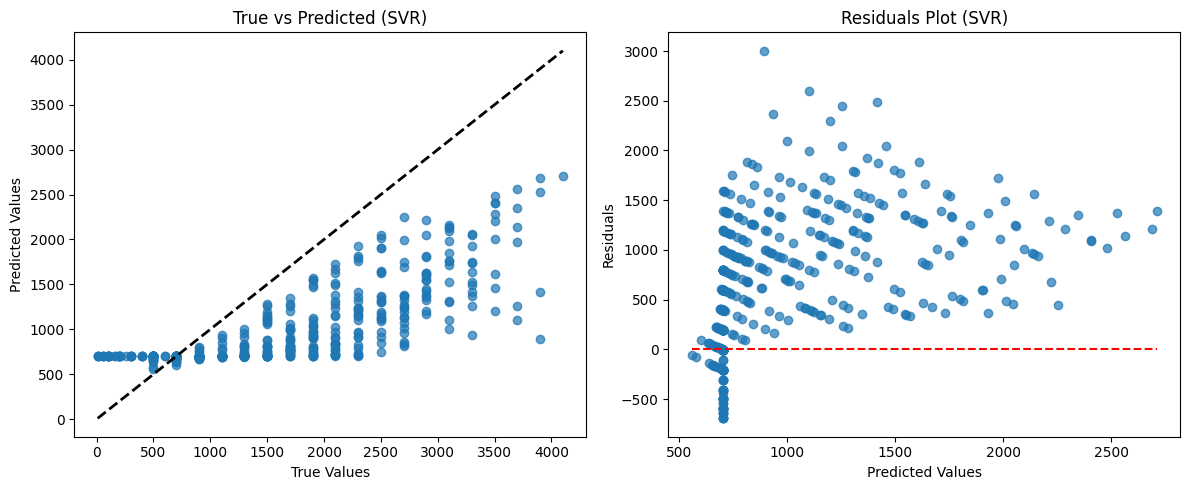

Training SVR for Avg_Sliding...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.1}
Best cross-validation score: 0.966187039737574
Mean Squared Error (MSE): 62149.7570
R² Score: 0.9619


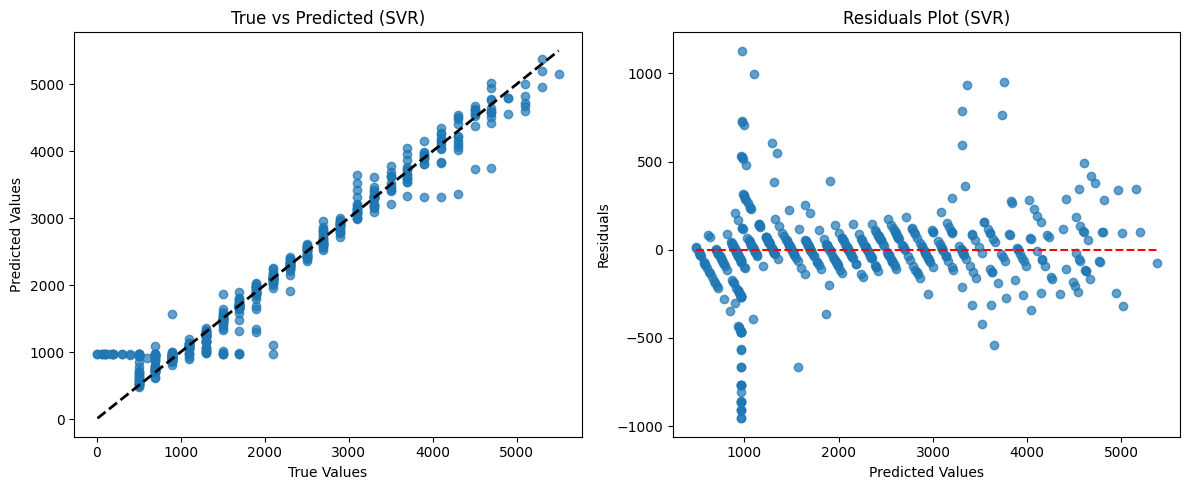

Training SVR for Avg_Partition...
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'auto'}
Best cross-validation score: 0.6271734469809592
Mean Squared Error (MSE): 9078.2986
R² Score: 0.6085


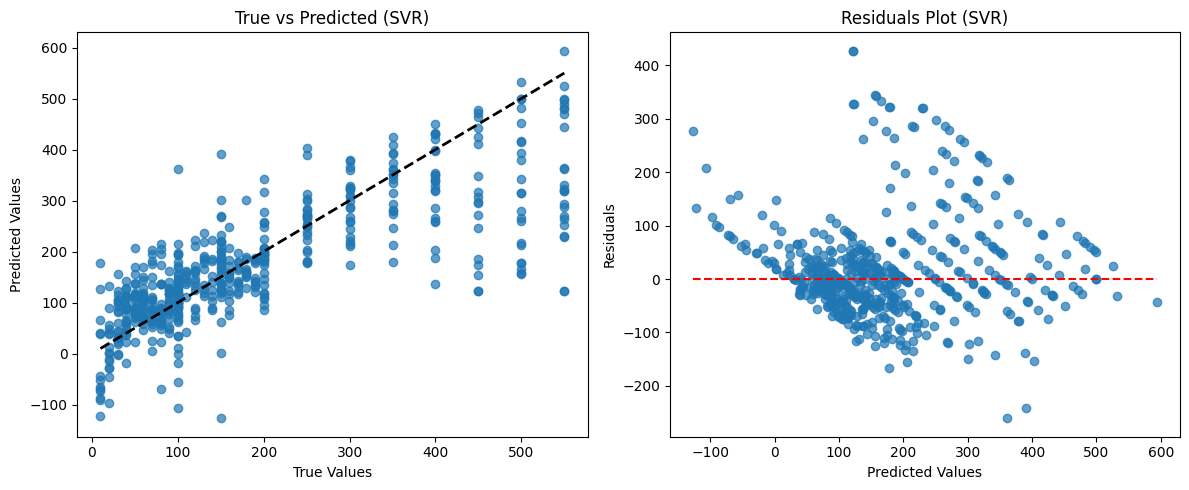

Training SVR for Count_By_Auction...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.9904984350150681
Mean Squared Error (MSE): 8.5681
R² Score: 0.9897


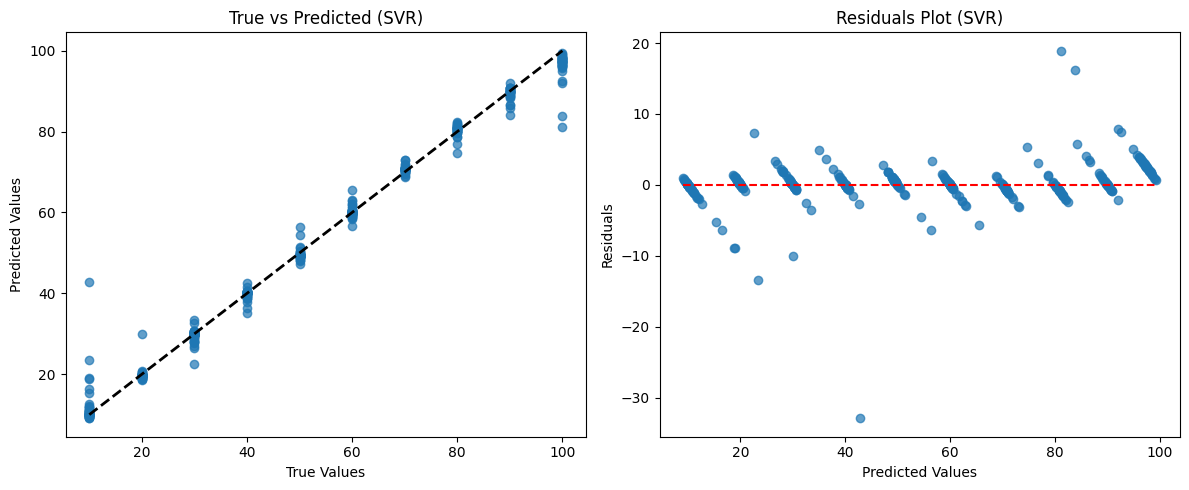

In [21]:
svr_sliding_step_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_sliding_step']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_sliding_step']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    svr_sliding_step_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    svr_sliding_step_models[operator]['model'], 
    svr_sliding_step_models[operator]['params'], 
    svr_sliding_step_models[operator]['scaler_x'], 
    svr_sliding_step_models[operator]['scaler_y'] = svr_grid_search(x_train, y_train, x_test, y_test)

# XGB

Training SVR for Join...
Mean Squared Error (MSE): 1480.0298
R² Score: 0.9290


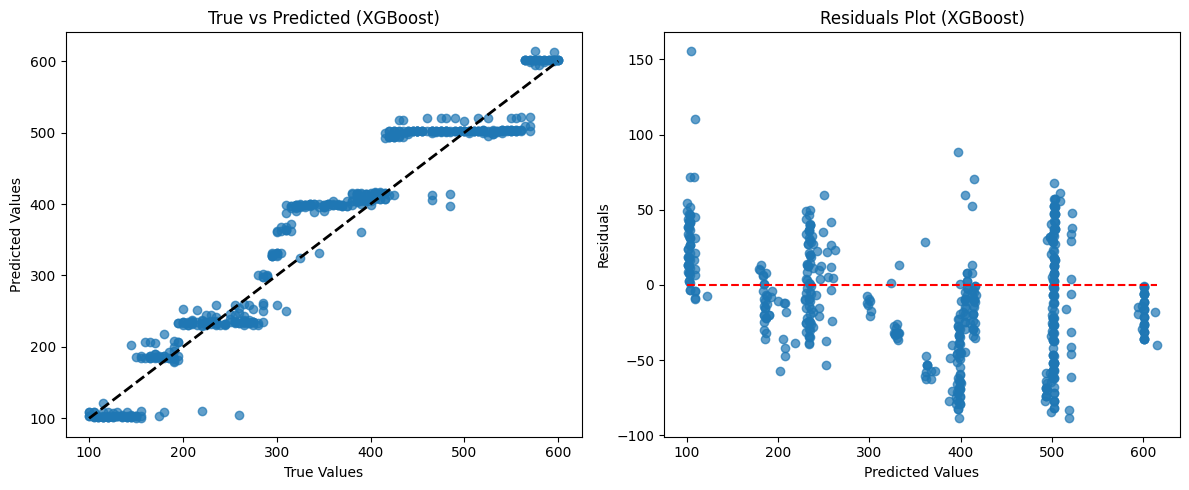

Training SVR for Max_GroupBy...
Mean Squared Error (MSE): 7379587.0000
R² Score: -2.5957


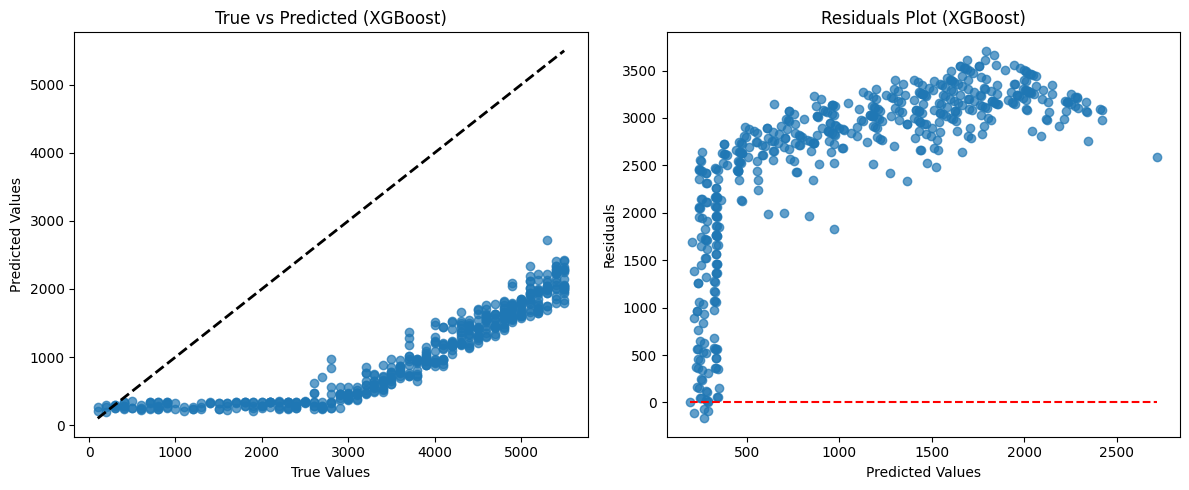

Training SVR for Avg_Sliding...
Mean Squared Error (MSE): 91725.5703
R² Score: 0.9752


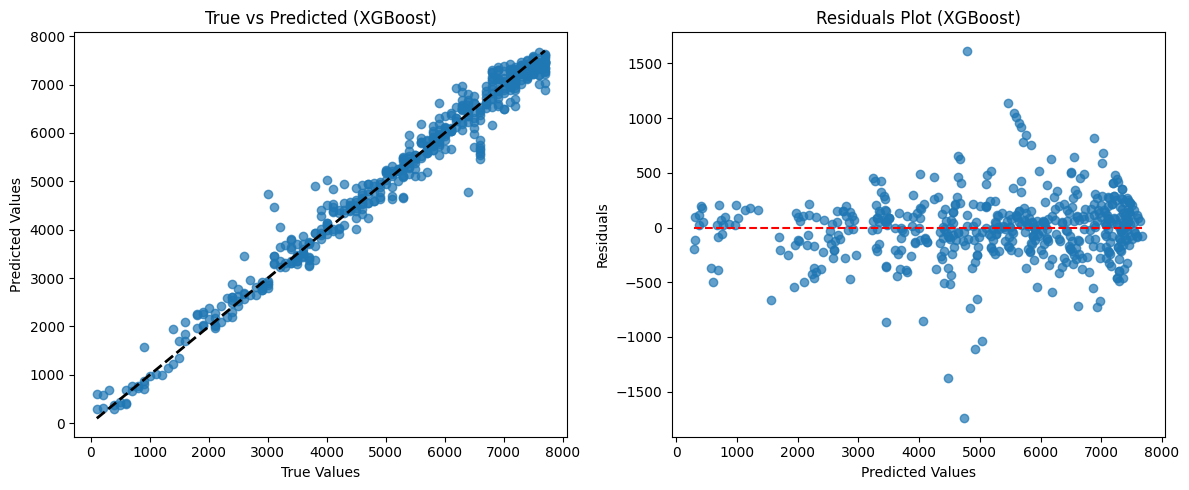

Training SVR for Avg_Partition...
Mean Squared Error (MSE): 115841.6094
R² Score: 0.8268


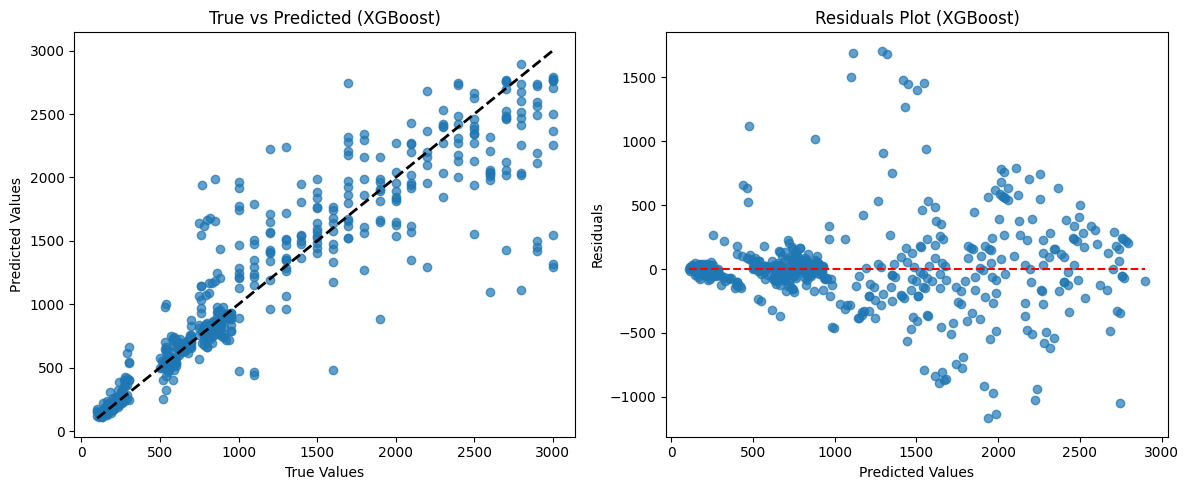

Training SVR for Count_By_Auction...
Mean Squared Error (MSE): 46.6233
R² Score: 0.9750


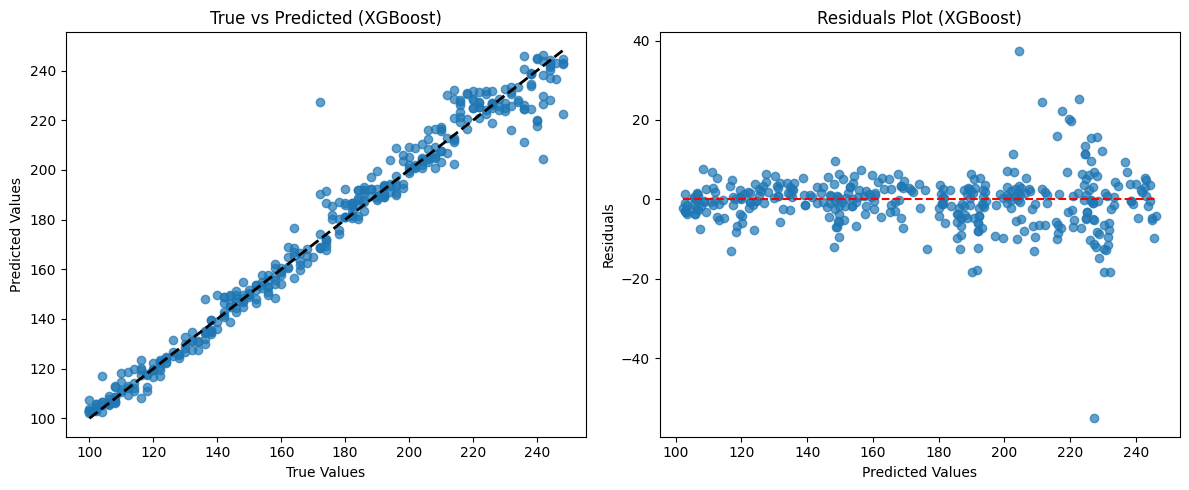

In [22]:
xgboost_window_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_window_time']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_window_time']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    xgboost_window_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    xgboost_window_models[operator]['model'], 
    xgboost_window_models[operator]['params'], 
    xgboost_window_models[operator]['scaler_x'], 
    xgboost_window_models[operator]['scaler_y'] = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)

Training XGB for Join...
Mean Squared Error (MSE): 692.8917
R² Score: 0.1613


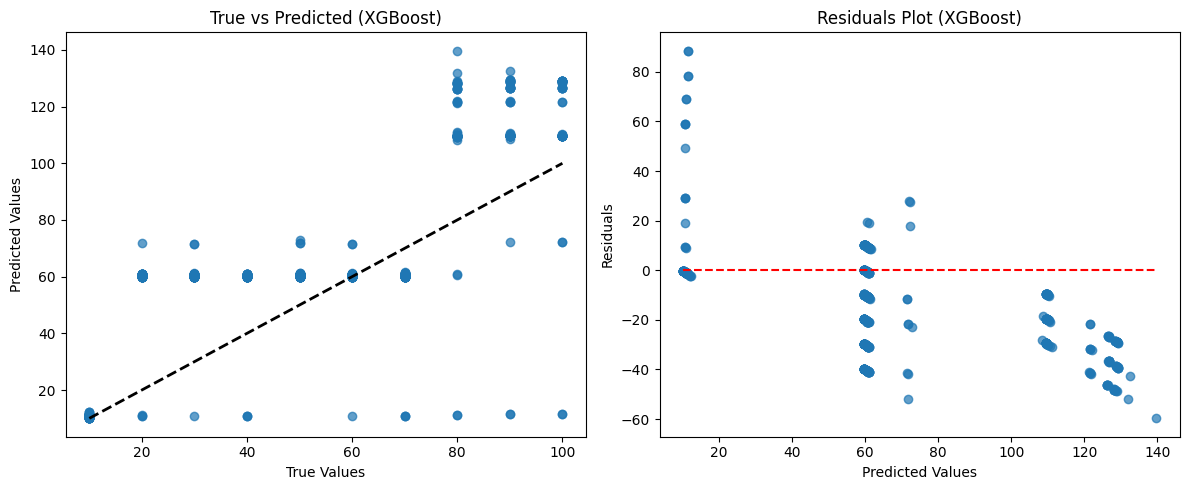

Training XGB for Max_GroupBy...
Mean Squared Error (MSE): 543616.3125
R² Score: 0.3815


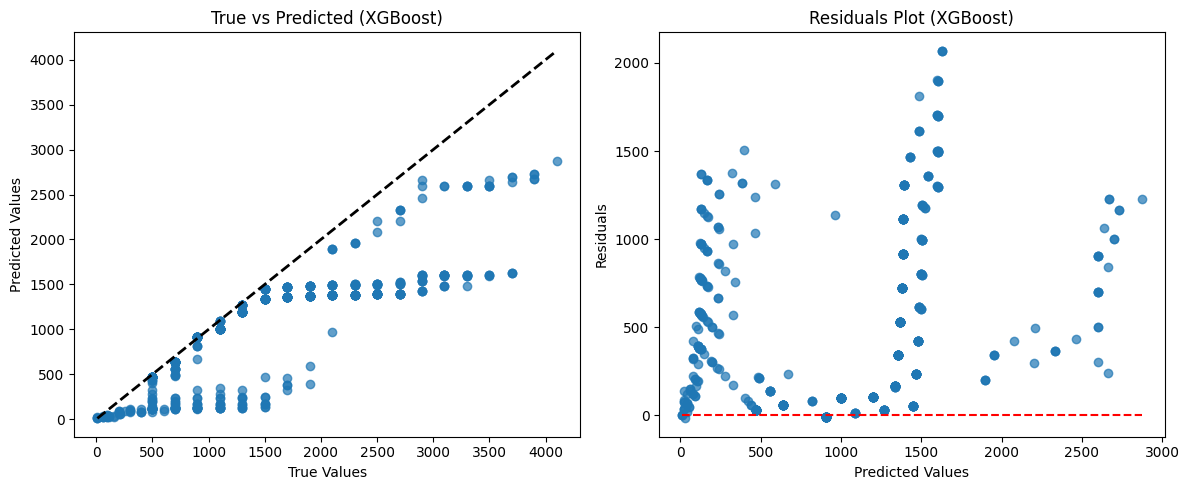

Training XGB for Avg_Sliding...
Mean Squared Error (MSE): 6106.9458
R² Score: 0.9963


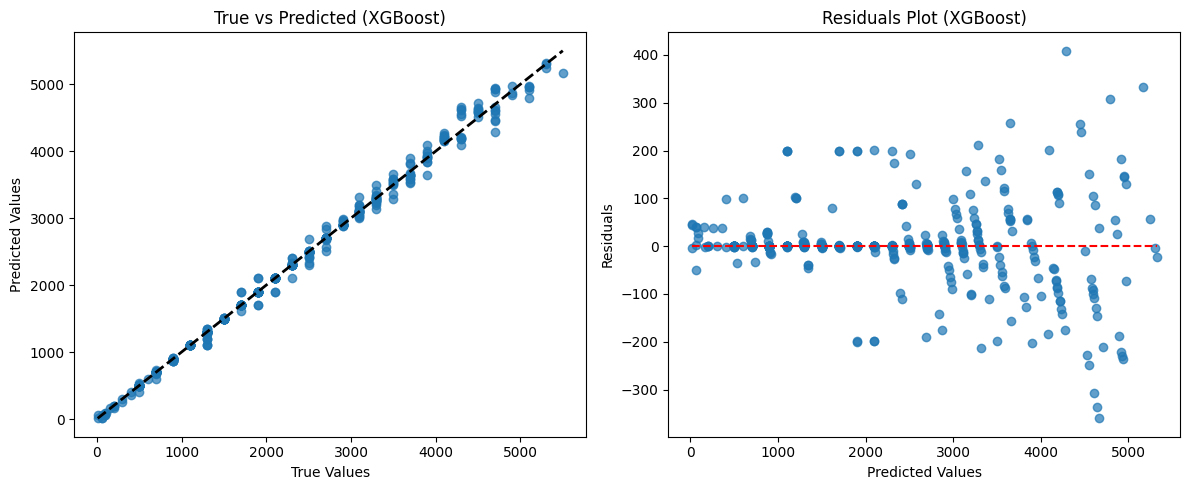

Training XGB for Avg_Partition...
Mean Squared Error (MSE): 4408.8350
R² Score: 0.8099


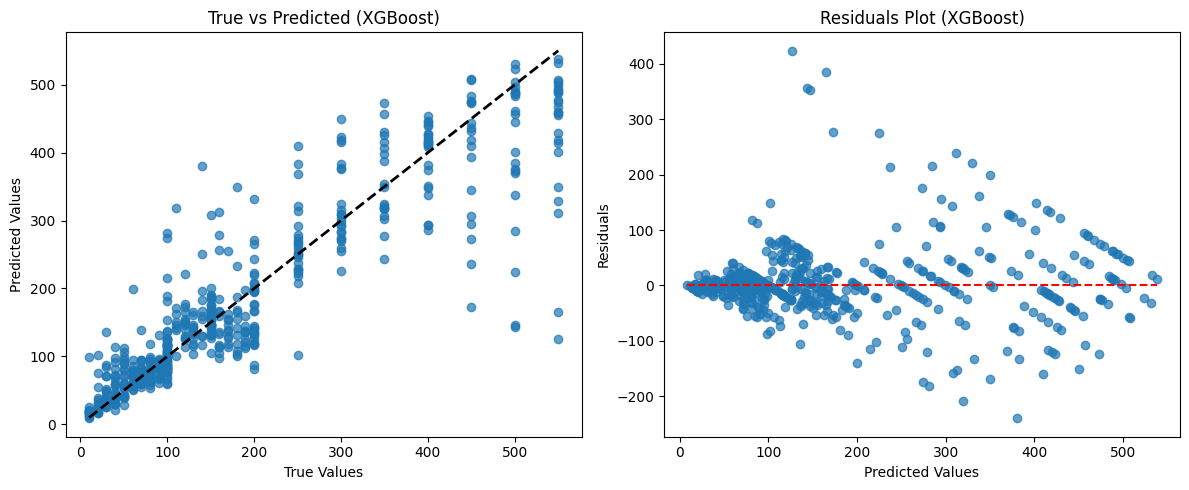

Training XGB for Count_By_Auction...
Mean Squared Error (MSE): 2.3996
R² Score: 0.9971


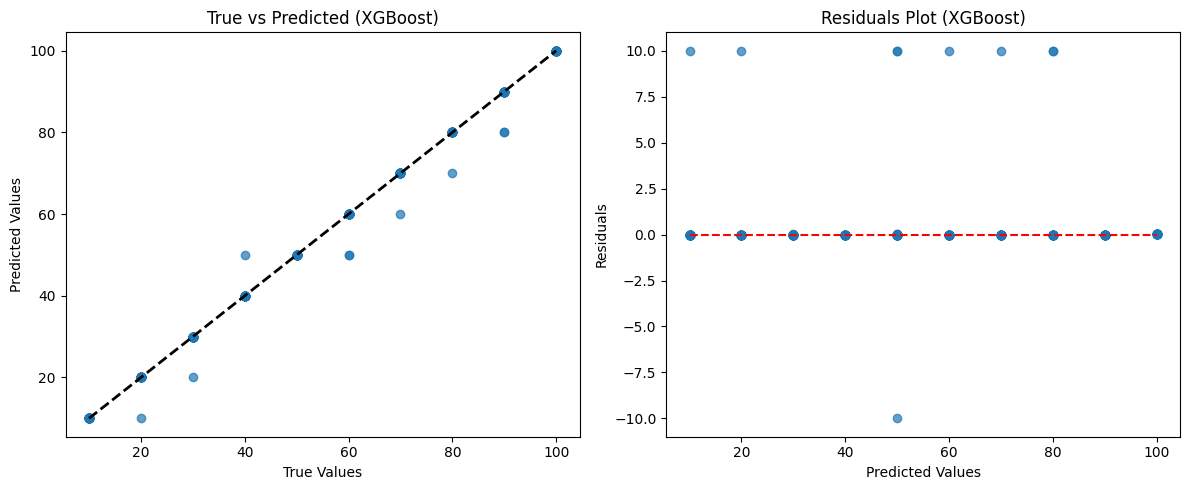

In [23]:
xgb_sliding_step_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_sliding_step']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_sliding_step']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training XGB for {operator}...")
    xgb_sliding_step_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    xgb_sliding_step_models[operator]['model'], 
    xgb_sliding_step_models[operator]['params'], 
    xgb_sliding_step_models[operator]['scaler_x'], 
    xgb_sliding_step_models[operator]['scaler_y'] = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)